# Classifying job vacancies for Boulo

Boulo is a recruiting platform focused on helping socially conscious companies access a hidden talent pool of diverse, experienced candidates-mostly women.

> 1. We want to enhance their **searching functionality** by classifying vacancies of the big 4 consulting companies (as proof-of-concept) per job function. We also try to extract other important information that is stated in the textual job vacancies. This makes it easier for candidates to help search jobs.
2. We want to use this classification in order to build a **dashboard** that gives big companies an overview of all their vacancies and compare them to similar vacancies in the market.

In [ ]:
# IDEA: Filter on seniority  -- Junior positions, senior positions, .... or years of work expierence
# IDEA: Filter on location?

## 1. Imports

### 1.1 Package Imports

This code installs all necessary **Python packages** for web scraping, data processing, and natural language processing using Playwright, BeautifulSoup, and HuggingFace Transformers. It then imports these libraries, applies nest_asyncio to allow nested event loops in asynchronous contexts, and sets up the environment for asynchronous scraping tasks.

In [ ]:
# * Install Required Packages
# Web scraping and browser automation
!pip install playwright httpx
!playwright install
# HTML parsing and data handling
!pip install requests beautifulsoup4 pandas
# NLP model support with HuggingFace and PyTorch
!pip install torch transformers
# Enable nested asyncio loops for Jupyter or similar environments
!pip install nest_asyncio
# Enable progress bars
!pip install ipywidgets tqdm
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py tqdm.notebook

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

In [ ]:
# * Import Python Libraries
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Graphs
import seaborn as sns # Pretty graphs :)
from collections import defaultdict # Counter

import time # Utility for adding delays
from tqdm.asyncio import tqdm_asyncio # Progress bars for asyncirious processes
from tqdm.notebook import tqdm

import requests # HTTP requests
import json # Handling JSON data
from bs4 import BeautifulSoup # HTML parser for web scraping
import re # Regular expressions for text parsing

import torch # PyTorch for model support
from transformers import AutoTokenizer, AutoModelForSequenceClassification # Transformers library for NLP models

import nest_asyncio # Allows running asyncio event loops in environments that already have a loop (e.g., Jupyter)
import asyncio # For asynchronous browser automation
from playwright.async_api import async_playwright

In [ ]:
# * Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

### 1.2 Model Imports

This code loads a pre-trained [HuggingFace](https://huggingface.co/rosherd/job_classification) transformer model (`rosherd/job_classification`) and its corresponding tokenizer for job classification tasks. It sets the model to evaluation mode, preparing it for inference without updating weights.

In [ ]:
# * Load model directly
tokenizer = AutoTokenizer.from_pretrained("rosherd/job_classification")  # Load the tokenizer for the specified job classification model
model = AutoModelForSequenceClassification.from_pretrained("rosherd/job_classification")  # Load the classification model itself
model.eval() # Set the model to evaluation mode (disables dropout and gradient updates)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

The output describes the architecture of a HuggingFace model, which is a fine-tuned version of **DistilBERT** for multi-class classification tasks. This specific model is designed to classify text into **2,123 unique classes**,  representing different job titles or roles.

The model consists of several key components:

1. Base Model: `DistilBertModel`. This is a lighter, faster variant of BERT, with 6 transformer layers instead of BERT’s original 12. It is composed of two main sub-parts:
     - Embeddings Layer:  
       - `word_embeddings`: Maps 30,522 unique tokens to 768-dimensional vectors.  
       - `position_embeddings`: Encodes position information for up to 512 tokens.  
       - `LayerNorm` and `Dropout`: Used to stabilize and regularize training.
     - Transformer Encoder:  Composed of 6 repeated `TransformerBlock` layers.   Each block has:
         - A multi-head self-attention mechanism (`DistilBertSdpaAttention`), including query, key, and value linear projections.
         - A feedforward neural network (FFN) with GELU activation.
         - Two `LayerNorm` layers, one applied after attention and one after the FFN.

2. Classification Head
   - `pre_classifier`: A linear layer that keeps the hidden dimension at 768.
   - `dropout`: Applied with a probability of 0.2 to prevent overfitting.
   - `classifier`: A linear layer mapping from 768 features to 2,123 output classes.

This architecture is optimized for text classification tasks, particularly where the number of classes is large. Given the final output size of 2,123, this model is suitable for applications such as **job title classification**, where the goal is to predict the correct class (job title) from an input text like a job description or resume snippet.

The call to `model.eval()` sets the model to **evaluation mode**, which disables dropout and other training-specific behavior. This ensures consistent output during inference.

## 2. Label exploration



### 2.1 Initial Job Fields & Job Titles

This code explores the classification labels of the model, where each label represents a job title and is structured as `field/job_title`.



In [ ]:
# * Print all label IDs and their corresponding job titles
print(model.config.id2label)

{0: 'Marketing/advertising_executive', 1: 'Marketing/brand_management', 2: 'Marketing/brand_specialist', 3: 'Marketing/campaign_manager', 4: 'Marketing/communications/communications_assistant', 5: 'Marketing/communications/communications_executive', 6: 'Marketing/communications/communications_manager', 7: 'Marketing/communications/communications_officer', 8: 'Marketing/communications/director_of_communications', 9: 'Marketing/demand-generation-marketer', 10: 'Marketing/digital_marketing/content_writer', 11: 'Marketing/digital_marketing/online_marketing_executive', 12: 'Marketing/digital_marketing/online_marketing_manager', 13: 'Marketing/digital_marketing/online_marketing_specialist', 14: 'Marketing/digital_marketing/social_media_content_specialist', 15: 'Marketing/digital_marketing/social_media_manager', 16: 'Marketing/digital_marketing/web_content_specialist', 17: 'Marketing/events_assistant', 18: 'Marketing/fashion_marketing_executive', 19: 'Marketing/field-market-representative', 2

It then extracts and lists all unique job fields by splitting each label at the slash and keeping only the first part (e.g., `'Marketing'` from `'Marketing/advertising_executive'`).

In [ ]:
# * Extract unique job fields (e.g., 'Marketing', 'Accounting', etc.)
fields = []
for label in model.config.id2label.values():
    field = label.split("/")[0]  # Get the field (first part before '/')
    if field not in fields:
        fields.append(field)     # Only keep unique fields

print(fields) # Display the unique job fields

['Marketing', 'account_management', 'accounting', 'administration', 'aerospace', 'agriculture', 'automotive', 'banking', 'buying_purchashing', 'charity_volunteer', 'cleaning', 'construction', 'consulting', 'cosmetology', 'council', 'creative_media_design', 'customer_services', 'education', 'energy', 'engineering', 'environmental', 'financial_services', 'graduate', 'healthcare', 'holiday_seasonal', 'hospitality', 'human_resources', 'human_services', 'insurance', 'internship', 'it_telecoms', 'legal', 'management', 'manufacturing', 'military_defence', 'multilingual', 'oil_and_gas', 'project_management', 'purchasing', 'real_estate', 'recruitment', 'retail', 'sales', 'science', 'security_safety', 'sports_fitness', 'strategy_consultancy', 'summer', 'training', 'transport_logistics', 'travel_tourism', 'veterinary_animal_care', 'warehouse', 'work_from_home']


This code counts how many job titles belong to each job field by parsing the model's label names. It then visualizes the distribution as a horizontal bar chart to highlight which fields have the most labeled job roles.

In [ ]:
# * Optional: Visualize number of job titles per field

# Dictionary to count job titles per field
field_counts = defaultdict(int)
# Loop over all label values (job titles with fields)
for label in model.config.id2label.values():
    field = label.split("/")[0]  # Extract the field
    field_counts[field] += 1     # Increment count for that field
# Convert to sorted list of tuples for display and plotting
sorted_field_counts = sorted(field_counts.items(), key=lambda x: x[1], reverse=True)

# Print number of fields and total job titles
print(f"Total job fields: {len(field_counts)}")
print(f"Total job titles: {len(model.config.id2label)}\n")

Total job fields: 54
Total job titles: 2123



In [ ]:
def format_field_name(field: str) -> str:
    """
    Formats a job field name by replacing underscores with spaces and applying title casing.

    Example:
        'human_resources' -> 'Human Resources'
        'it_telecoms'     -> 'It Telecoms'
    """
    return field.replace("_", " ").title()

<ipython-input-62-978215a002f7>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




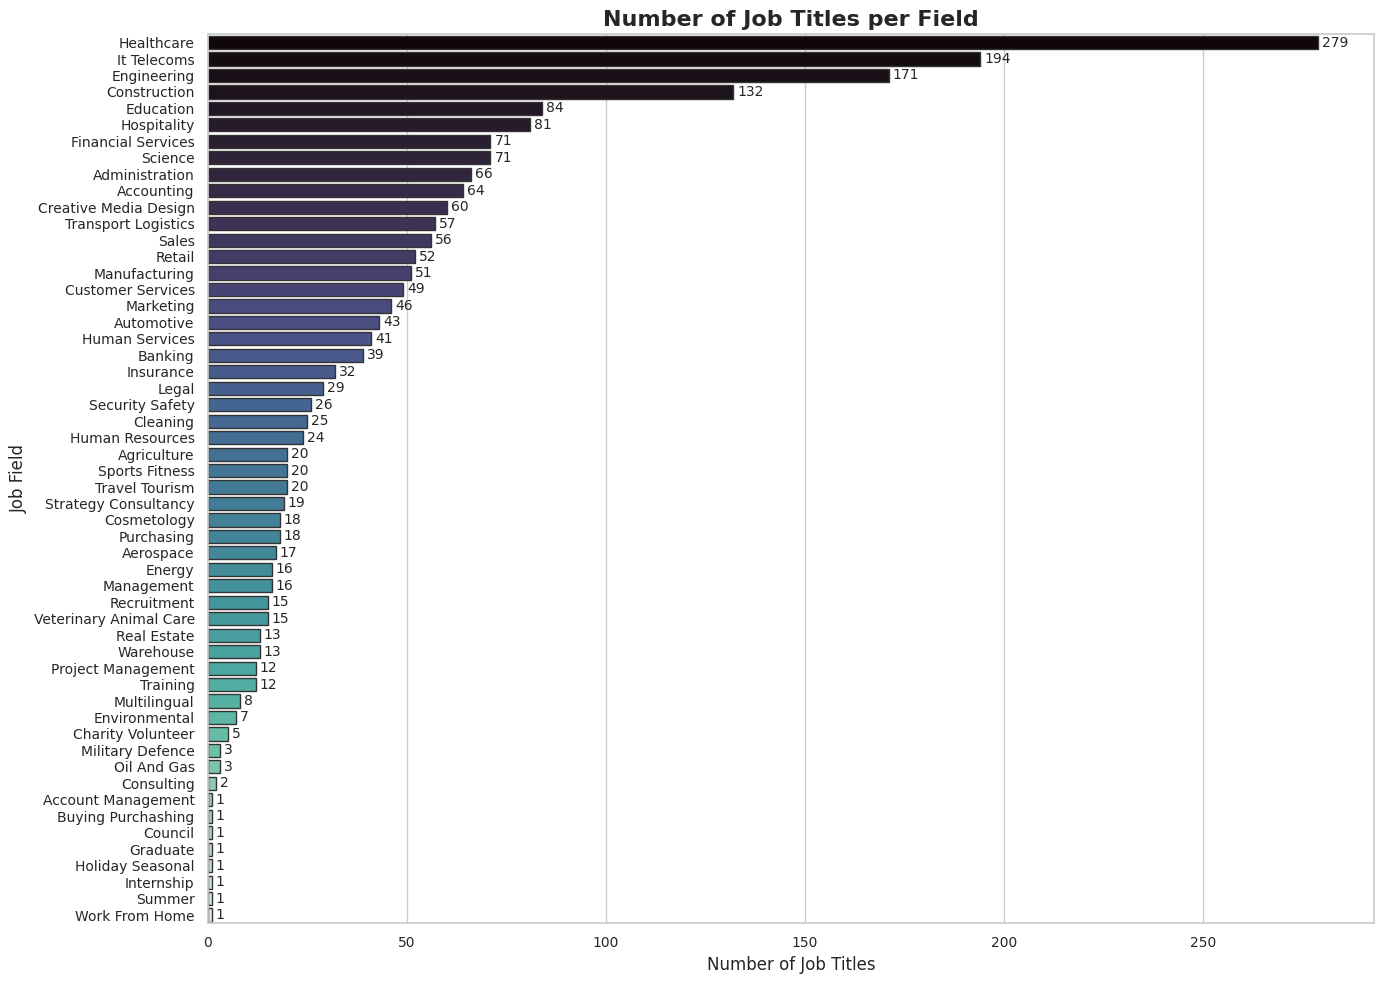

In [ ]:
# Plot as horizontal bar chart
df = pd.DataFrame(sorted_field_counts, columns=["Field", "Job Title Count"])
df["Field"] = df["Field"].apply(format_field_name) # Apply formatting to the DataFrame
sns.set(style="whitegrid") # Set Seaborn style
# Create horizontal bar plot
plt.figure(figsize=(14, 10))
barplot = sns.barplot(
    data=df,
    y="Field",
    x="Job Title Count",
    palette="mako",  # You can try "mako", "cubehelix", "coolwarm", etc.
    edgecolor=".2"
)
# Improve plot aesthetics
barplot.set_title("Number of Job Titles per Field", fontsize=16, weight='bold')
barplot.set_xlabel("Number of Job Titles", fontsize=12)
barplot.set_ylabel("Job Field", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
# Add count labels at the end of each bar
for i, (count) in enumerate(df["Job Title Count"]):
    barplot.text(
        x=count + 1,  # Slightly outside the bar
        y=i,
        s=str(count),
        va='center',
        fontsize=10
    )
# Show plot
plt.tight_layout()
plt.show()

### 2.2 Cleaning the labels

This function organizes job labels into a 3-level hierarchy: `domain / original_field / job_title`
- job_title: specific role (e.g. "auditor"). taken directly from the output label after the slash.
- original_field: taken directly from the output label before the slash (e.g. "Banking")
- domain: a new broader grouping, manually mapped (e.g. "finance")

The function doesn't alter the existing label structure — it just adds a top-level job domain based on the original job field or title. If no match is found, it assigns "other" as the domain.

In [ ]:
def clean_label_hierarchy(label: str) -> str:
    """
    Maps a raw job label to a structured 3-level format:
    domain / original_field / job_title

    The function preserves the original field and title from the label,
    and prepends a broader job domain based on keyword matching.

    Args:
        label (str): Original job label, e.g. 'Banking/auditor'

    Returns:
        str: Structured label, e.g. 'finance/Banking/auditor'
    """
    label_lower = label.lower()

    # Define keyword-based mapping: domain → keywords
    domain_keywords = {
        "finance": [
            "finance", "financial_services", "accounting", "accountant",
            "banking", "auditor", "audit", "tax", "treasury",
            "actuarial", "cfo", "controller"
        ],
        "sales": [
            "sales", "account_management", "business_development",
            "retail", "customer_service_sales", "call_center_sales",
            "cs_account_manager", "new_business", "key_account"
        ],
        "engineering": [
            "engineering", "engineer", "developer", "technician",
            "mechanic", "fabricator"
        ],
        "supply_chain": [
            "supply_chain", "logistics", "transport", "warehouse",
            "inventory", "distribution", "purchasing", "procurement",
            "materials", "order_picker"
        ]
    }

    # Default domain if no match found
    domain = "other"

    # Match based on keyword presence in label
    for dom, keywords in domain_keywords.items():
        if any(kw in label_lower for kw in keywords):
            domain = dom
            break

    # Extract original field and title
    if "/" in label:
        field, title = label.split("/", 1)
    else:
        field = label
        title = label

    return f"{domain}/{field}/{title}"

## 3. Classifying Vacancies

This notebook scrapes job vacancies from the careers websites of Big Four companies, classifies them using the pre-trained transformer model, and exports the results as a structured CSV. Each job is labeled with a hierarchical prediction in the format `domain/field/title` for improved categorization and analysis.

The process includes:
1. Scraping structured job data using `Playwright`
2. Classifying roles with a HuggingFace model
3. Enriching the labels using a custom taxonomy
4. Tracking progress using progress bars for scraping and classification

### 3.1 Transforming labels

This function takes a list of jobs from a website (each with a title and description), runs them through a pre-trained classification model, and predicts a job label (`field/title`) for each. It then cleans and structures the predicted label into a 3-level hierarchy (`domain/field/title`) using the `clean_label_hierarchy()` function and returns the enhanced job records.



In [ ]:
# === 1) Job Classification Wrapper ===
def classify_jobs_with_model(jobs):
    """
    Classifies a list of job entries using a transformer model and returns
    each job annotated with a structured predicted label (domain/field/title).

    Args:
        jobs (list[dict]): List of jobs with 'title' and 'description' keys.

    Returns:
        list[dict]: Original jobs with added key "Predicted Class".
    """
    results = []
    for job in jobs:
        # Prepare model input: combine title and description
        text = f"{job['title']}: {job['description']}"
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        # Perform inference without computing gradients
        with torch.no_grad():
            logits = model(**inputs).logits
        pred_id = logits.argmax().item() # Get predicted label ID (highest score)
        raw_label = model.config.id2label[pred_id] # Get raw string label from model's label mapping
        structured_label = clean_label_hierarchy(raw_label) # Clean and structure the label hierarchically
        # Append result with prediction
        results.append({
            **job,
            "Predicted Class": structured_label
        })
    return results

### 3.2 Website Scrapers

#### 3.2.1 Deloitte

This function uses Playwright to asynchronously navigate Deloitte Belgium's job listings. It loops through paginated results, scrapes job title, description, and location, and stores them in a standardized format. Duplicate titles are skipped.


In [ ]:
# === 2) Deloitte Scraper ===
async def fetch_jobs_from_deloitte():
    jobs, seen = [], set()

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://deloittebe.avature.net/en_US/careers/SearchJobs/")
        await page.wait_for_selector("table#dashboardTopPositions tbody tr.card--box", timeout=20000)

        page_num = 1
        while True:
            print(f"Deloitte: scraping page {page_num}...")
            rows = await page.query_selector_all("table#dashboardTopPositions tbody tr.card--box")

            for row in rows:
                a = await row.query_selector("h3.article__header__text__title a")
                title = (await a.text_content()).strip() if a else ""
                if not title or title in seen:
                    continue
                seen.add(title)

                info = await row.query_selector("div.article__header__text__subtitle__list")
                txt  = await info.inner_text() if info else ""

                f = re.search(r"Field of Interest:\s*(.*?)\s*(\||$)", txt)
                i = re.search(r"Industry:\s*(.*?)\s*(\||$)", txt)
                l = re.search(r"Location:\s*(.*?)\s*(\||$)", txt)

                jobs.append({
                    "title":       title,
                    "description": f"{(f.group(1) if f else '').strip()} - {(i.group(1) if i else '').strip()}",
                    "location":    (l.group(1) if l else "").strip(),
                    "Company":     "Deloitte"
                })

            # Move to the next page, if available
            nxt = await page.query_selector("a.paginationNextLink")
            if not nxt:
                print("✅ Deloitte: all pages scraped.")
                break
            await nxt.click()
            await page.wait_for_selector("table#dashboardTopPositions tbody tr.card--box", timeout=20000)
            await page.wait_for_timeout(500)
            page_num += 1

        await browser.close()

    return jobs

#### 3.2.2 Ernst & Young

This function scrapes job listings from EY Belgium's careers site. It navigates paginated job posts, extracts job title, location, service line, and sector, and returns a list of standardized job dictionaries.

In [ ]:
# === 2) EY Scraper ===
async def fetch_jobs_from_ey():
    jobs, seen = [], set()  # jobs is a list, seen is a set
    results = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto("https://eycareers.be/vacancies/")
        await page.wait_for_selector("div.vacature", timeout=20000)

        page_num = 1
        while True:
            print(f"EY: scraping page {page_num}...", flush=True)

            # Select all job cards
            cards = await page.query_selector_all("div.vacature")
            for card in cards:
                # 🎯 Job title
                h3 = await card.query_selector("h3")
                title = (await h3.text_content()).strip() if h3 else ""
                if not title or title in seen:
                    continue
                seen.add(title)

                # 🌍 Metadata: location, service, sector
                spans = await card.query_selector_all(".vacature-info-icons span")
                location = (await spans[0].text_content()).strip() if len(spans) > 0 else ""
                service  = (await spans[1].text_content()).strip() if len(spans) > 1 else ""
                sector   = (await spans[2].text_content()).strip() if len(spans) > 2 else ""

                # 📝 Add standardized job entry
                results.append({
                    "title":       title,
                    "description": f"{service} - {sector}",
                    "location":    location,
                    "Company":     "Ernst & Young"
                })

            # ⏭️ Check if next page exists
            next_sel = f"div.pagination a:text-is('{page_num+1}')"
            nxt = await page.query_selector(next_sel)
            if not nxt:
                print("✅ EY: all pages scraped.", flush=True)
                break

            await nxt.click()
            await page.wait_for_selector("div.vacature", timeout=20000)
            await page.wait_for_timeout(500)
            page_num += 1

        await browser.close()

    return results

#### 3.2.3 KPMG

This function uses the Workday backend JSON API to fetch job listings from KPMG Belgium. It normalizes job data into the expected structure.

In [ ]:
# === 3) KPMG Scraper ===
from playwright.async_api import async_playwright
import re

async def fetch_jobs_from_kpmg():
    """
    Scrapes job listings from KPMG Belgium's career site using Playwright.
    Extracts job title, department, and location for each posting.

    Returns:
        list[dict]: A list of job dicts with title, description, location, and company.
    """
    jobs = []
    seen = set()
    base_url = "https://kpmg-career.talent-soft.com/job/list-of-jobs.aspx?LCID=2057"
    page_number = 1

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        while True:
            url = f"{base_url}&page={page_number}"
            print(f"🔍 KPMG: scraping page {page_number}...", flush=True)
            await page.goto(url)
            try:
                await page.wait_for_selector("li.ts-offer-list-item", timeout=20000)
            except:
                print(f"⚠️ KPMG: failed to load page {page_number}")
                break

            # Grab all job cards
            job_cards = await page.query_selector_all("li.ts-offer-list-item")

            for card in job_cards:
                # Title
                title_elem = await card.query_selector("h3 a")
                title = (await title_elem.inner_text()).strip() if title_elem else ""
                if not title or title in seen:
                    continue
                seen.add(title)

                # Job metadata: department and location
                meta_items = await card.query_selector_all("ul.ts-offer-list-item__description li")
                metadata = [await item.inner_text() for item in meta_items]
                department = metadata[2] if len(metadata) > 2 else ""
                location = metadata[3] if len(metadata) > 3 else ""

                jobs.append({
                    "title": title,
                    "description": department,
                    "location": location,
                    "Company": "KPMG"
                })

            # Check if there's a next page
            next_link = await page.query_selector("li.ts-ol-pagination-list-item--next span")
            if next_link:
                page_number += 1
                await page.wait_for_timeout(500)
            else:
                print("✅ KPMG: all pages scraped.")
                break

        await browser.close()

    return jobs


#### 3.2.4 PWC

Lastly, this one does the same for PwC:

In [ ]:
from playwright.async_api import async_playwright
import re, json, asyncio

async def fetch_jobs_from_pwc():
    """
    Fetches PwC Belgium Experienced Candidates job postings by
    extracting the inline `jsondata` array from the page's script.
    Returns a list of dicts with keys: title, description (line of service), location, Company.
    """
    url = (
        "https://www.pwc.be/en/careers/experienced-candidates/"
        "job-results.html?wdcountry=BEL&wdjobsite=Global_Experienced_Careers"
    )
    jobs = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url)
        await page.wait_for_load_state("load")

        # Find the <script> that defines `var jsondata = [...]`
        for script in await page.query_selector_all("script"):
            text = await script.inner_text()
            if "var jsondata" in text:
                m = re.search(r"var\s+jsondata\s*=\s*(\[\{.*?\}\])\s*;", text, re.S)
                if m:
                    data = json.loads(m.group(1))
                    for item in data:
                        jobs.append({
                            "title":       item.get("title", "").strip(),
                            "description": item.get("los",   "").strip(),    # line of service
                            "location":    item.get("location", "").strip(),
                            "Company":     "PwC"
                        })
                break

        await browser.close()
    return jobs

### 3.3 Actual Predicting

This function processes a list of job dictionaries, tokenizes their content, predicts job categories using a model, and applies the `clean_label_hierarchy` function. A progress bar shows the classification progress.

In [ ]:
# === 6) Classification with Progress Bar ===
def classify_jobs_with_model(jobs):
    """
    Classifies job entries and appends a hierarchical predicted label to each.

    Args:
        jobs (list[dict]): List of jobs with 'title' and 'description'.

    Returns:
        list[dict]: List with added "Predicted Class" field.
    """
    results = []
    for job in tqdm(jobs, desc="🔮 Predicting job classes"):
        text = f"{job['title']}: {job['description']}"
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

        with torch.no_grad():
            logits = model(**inputs).logits

        pred_id = logits.argmax().item()
        raw_label = model.config.id2label[pred_id]
        structured_label = clean_label_hierarchy(raw_label) # Actually appl y the work flow. Rest is progress bar.

        results.append({**job, "Predicted Class": structured_label})

    return results

This function coordinates scraping from all companies, classifies the jobs, displays total progress, and saves the result to a CSV.

In [ ]:
# === 3) Full Async Pipeline ===
async def main():
    print("🌐 Starting scraping process...")

    # ⏳ Scrape each company with visible progress
    dt_jobs = await fetch_jobs_from_deloitte()
    ey_jobs = await fetch_jobs_from_ey()  # assume defined similarly
    kpmg_jobs = await fetch_jobs_from_kpmg()
    pwc_jobs = await fetch_jobs_from_pwc()

    all_jobs = dt_jobs + ey_jobs + kpmg_jobs + pwc_jobs
    print(f"\n📦 Total scraped: {len(all_jobs)} job postings\n")

    if not all_jobs:
        print("⚠️ No job listings found. Please check the URLs or selectors.")
        return

    # 🔍 Predict categories with model
    classified_jobs = classify_jobs_with_model(all_jobs)

    # 📊 Format and save results
    df = pd.DataFrame(classified_jobs)[[
        "Company", "title", "description", "location", "Predicted Class"
    ]].rename(columns={
        "title": "Job Function",
        "description": "Job Description",
        "location": "Location"
    })

    df.to_csv("jobs_final.csv", index=False)
    print("✅ Saved CSV: 'jobs_final.csv'")
    df.head()

In [ ]:
# To run entire program
await main()

🌐 Starting scraping process...
Deloitte: scraping page 1...
Deloitte: scraping page 2...
Deloitte: scraping page 3...
Deloitte: scraping page 4...
Deloitte: scraping page 5...
Deloitte: scraping page 6...
Deloitte: scraping page 7...
Deloitte: scraping page 8...
Deloitte: scraping page 9...
Deloitte: scraping page 10...
Deloitte: scraping page 11...
Deloitte: scraping page 12...
Deloitte: scraping page 13...
Deloitte: scraping page 14...
✅ Deloitte: all pages scraped.
EY: scraping page 1...
EY: scraping page 2...
EY: scraping page 3...
EY: scraping page 4...
EY: scraping page 5...
EY: scraping page 6...
EY: scraping page 7...
EY: scraping page 8...
EY: scraping page 9...
EY: scraping page 10...
EY: scraping page 11...
EY: scraping page 12...
EY: scraping page 13...
✅ EY: all pages scraped.
🔍 KPMG: scraping page 1...
✅ KPMG: all pages scraped.

📦 Total scraped: 467 job postings



🔮 Predicting job classes:   0%|          | 0/467 [00:00<?, ?it/s]

✅ Saved CSV: 'jobs_final.csv'


Let's now display the results in a convient way.

In [ ]:
from IPython.display import display, HTML
def show_scrollable_df(df, height=400, width="100%"):
    """
    Displays a scrollable DataFrame in Jupyter notebook with both vertical and horizontal scroll.

    Args:
        df (pd.DataFrame): DataFrame to display
        height (int): Scroll box height in pixels
        width (str): Width of scroll box (e.g., "100%" or "800px")
    """
    html = f"""
    <div style="
        height: {height}px;
        width: {width};
        overflow: auto;
        border: 1px solid #ccc;
        padding: 5px;
    ">
        {df.to_html(index=False)}
    </div>
    """
    display(HTML(html))

In [ ]:
df = pd.read_csv("jobs_final.csv")
show_scrollable_df(df)

Company,Job Function,Job Description,Location,Predicted Class
Deloitte,.Net Developer,Technology - Industry Agnostic,Zaventem,engineering/it_telecoms/developer/web_developer/dot_net_developer/net_architect
Deloitte,(Jr.) Management Assistant,Business Support - Industry Agnostic,Zaventem,other/strategy_consultancy/business_advisor
Deloitte,(Junior) Legal consultant business/commercial law,Legal Services - Industry Agnostic,Ghent,other/legal/general_legal_counsel
Deloitte,(Senior) Consultant - Consolidation (SAP Group Reporting),Finance & Risk - Industry Agnostic,Zaventem,finance/financial_services/financial_services_consultant
Deloitte,(Senior) Consultant - EPM - Anaplan Operate,Finance & Risk - Industry Agnostic,Zaventem,finance/financial_services/financial_services_consultant
Deloitte,(Senior) Consultant - EPM - SAC,Technology - Industry Agnostic,Zaventem,finance/banking/banking_analyst
Deloitte,(Senior) Consultant - EPM Anaplan,Finance & Risk - Industry Agnostic,Zaventem,finance/financial_services/financial_services_consultant
Deloitte,(Senior) Consultant Logistics Technology,Technology - Industry Agnostic,Zaventem,supply_chain/transport_logistics/transport_logistics_team_leader
Deloitte,(Senior) Consultant M&A Transactions Services,Finance & Risk - Industry Agnostic,Zaventem,finance/financial_services/financial_services_consultant
Deloitte,(Senior) Manager M&A Transactions Services – Real Estate,Finance & Risk - Financial Services,Zaventem,other/real_estate/realtor


In [79]:
from google.colab import files
files.download("jobs_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Dashboard

Now we will make a seperate python file with code for our dashboard. You can find it in files. This code writes the file and the correct code in it:

In [81]:
# TODO Adjust this with final code

code = """
import pandas as pd
import streamlit as st
import plotly.express as px

@st.cache
def load_data():
  # Load your data
  df = pd.read_csv("jobs_final.csv")
  df["Predicted domain"] = df["Predicted Class"].apply(lambda x: format_field_name(x.split("/")[0]))
  df["Predicted field"] = df["Predicted Class"].apply(lambda x: format_field_name(x.split("/")[1]))
  df["Predicted title"] = df["Predicted Class"].apply(lambda x: format_field_name(x.split("/")[2]))
  return df

def compute_comparison(df, company):
    metrics = ['salary_estimate','years_experience']
    sel = df[df['Company']==company][metrics].mean()
    avg = df.groupby('Company')[metrics].mean().mean()
    return pd.DataFrame([sel, avg], index=[company,'Big4 Average'])

def main():
    st.title("Big 4 Benchmark")
    df = load_data()
    firm = st.sidebar.selectbox("Select firm", df['Company'].unique())
    comp = compute_comparison(df, firm)
    st.dataframe(comp)
    fig = px.bar(comp.reset_index().melt(id_vars='index'),
                 x='variable', y='value', color='index',
                 barmode='group')
    st.plotly_chart(fig, use_container_width=True)

if __name__=='__main__':
    main()
"""
with open('dashboard.py','w') as f:
    f.write(code)

files.download("dashboard.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I have added both files and a requirements.txt to my Github: .
Then I have deployed the dashboard on Streamlit Community Cloud by linking my GitHub repo: